Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [4]:
import os, re, string

In [10]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [11]:
FN = 'vocabulary-embedding'

In [12]:
seed=42

In [13]:
vocab_size = 40000

In [14]:
embedding_dim = 100

In [15]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

1. DeepMind Q&A Dataset CNN questions were used here. Please download at https://cs.nyu.edu/~kcho/DMQA/.
2. Unzip cnn.tgz inside `../dataset` folder. Or, any path of your choice though please remember to change `dataset_path` variable below.

In [16]:
num_samples = 100000
dataset_path = "{}/dataset/cnn/questions".format(root_path)

In [17]:
#import cPickle as pickle
#FN0 = 'tokens' # this is the name of the data file which I assume you already have
#with open('data/%s.pkl'%FN0, 'rb') as fp:
#    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project
def get_huge_dataset_list(path, limit=0):
    """
    Generator to help go through huge number of files under a path.
    By default, it generates all filenames.
    Set limit with any value > 0 to generate a limited number of filenames.  
    """
    count = 0
    for file in os.listdir(path): 
        yield file
        count = count + 1
        if count == limit and limit > 0:
            break

In [18]:
training_data_path = "{}/training".format(dataset_path)
heads = []
desc = []
keywords = []
for filename in get_huge_dataset_list(path=training_data_path, limit=num_samples):
    file = open("{}/{}".format(training_data_path, filename), "r", encoding="utf8")
    lines = file.readlines()
    
    # Get keywords
    entity_keywords = dict()
    r = re.compile("^(\@entity\d+):(.+)$")
    for line in lines:
        m = re.search(r, line)
        if m:
            entity_keywords[m.group(1)] = m.group(2) # used to substitute back into desc and headline
            keywords.append(m.group(2).split())
    
    desc_alltext = lines[2].split('.')
    desc_text = ''.join(desc_alltext[1:4])
    head_text = lines[4].strip()
    head_text = head_text.replace('@placeholder', '')
    for entity, keyword in entity_keywords.items():
        # print(entity, keyword)
        desc_text = desc_text.replace(entity + ' ', keyword + ' ')
        head_text = head_text.replace(entity + ' ', keyword + ' ')
    # desc_text = re.sub(re.compile('[{}]'.format(string.punctuation)), '', desc_text)
    # print(desc_text)
    # print(head_text)
    desc.append(desc_text)
    heads.append(head_text)
    

In [19]:
if lower:
    heads = [h.lower() for h in heads]

In [20]:
if lower:
    desc = [h.lower() for h in desc]

In [21]:
i=0
heads[i]

"Kenya 's  1920s Camp Cottars kits out staff in vintage livery"

In [22]:
desc[i]

' we \'re not talking about the " Big Five " beasts -- lion , leopard , elephant , rhino , buffalo -- that people pay top dollar to see  we \'re talking about the accommodations  for those with budgets as grand as the sweeping plains of southern and eastern Africa , exploring the wilderness need n\'t come at the expense of luxury '

In [23]:
keywords[i]

['Lake', 'Manyara', 'Tree', 'Lodge']

In [24]:
len(heads),len(set(heads))

(100000, 98592)

In [25]:
len(desc),len(set(desc))

(100000, 57255)

# build vocabulary

In [26]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [27]:
vocab, vocabcount = get_vocab(heads+desc)

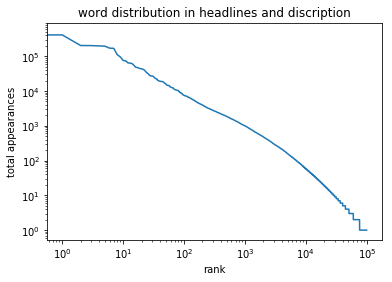

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [29]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [30]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [31]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe - https://nlp.stanford.edu/projects/glove/

In [33]:
fname = 'glove.6B.%dd.txt'%embedding_dim
#import os
#datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
#if not os.access(datadir_base, os.W_OK):
#    datadir_base = os.path.join('/tmp', '.keras')
#datadir = os.path.join(datadir_base, 'datasets')
#glove_name = os.path.join(datadir, fname)
#if not os.path.exists(glove_name):

datadir = '{}/dataset'.format(root_path)
path = 'glove.6B.zip'
#!wget http://nlp.stanford.edu/data/glove.6B.zip --directory-prefix={datadir}
#!unzip {datadir}/{path} -d {datadir}

In [34]:
glove_name = os.path.join(datadir, fname)
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [35]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        # glove_embedding_weights[i,:] = map(float,l[1:]) # python 2 only
        glove_embedding_weights[i,:] = [float(s) for s in l[1:]]
        i += 1
glove_embedding_weights *= globale_scale

In [36]:
glove_embedding_weights.std()

0.04081572760019029

In [37]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [38]:

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 38851 0.971275


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [39]:
glove_thr = 0.5

In [40]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [41]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 36937


manually check that the worst substitutions we are going to do are good enough

In [42]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.5000617289543017 Fernie => Revelstoke
0.500059503621102 Uma => Felicity
0.5000359537051505 Wlodzimierz => Yatsenyuk
0.5000352330483213 voicemails => e-mails
0.500020580210053 psychodrama => angst
0.5000186032451982 Menaka => Raqqa
0.5000185560208197 ditto => oxymoron
0.5000037989997332 MAIA => Joanna
0.5000037101336479 Yunior => Lomong
0.5000029520994946 Agos => Al-Ahram


build a lookup table of index of outside words to index of inside words

In [43]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [44]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

100000

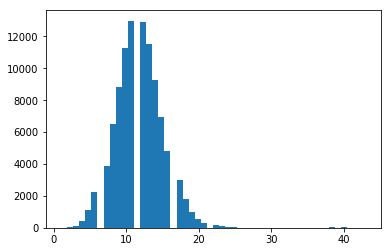

In [45]:
plt.hist(list(map(len,Y)),bins=50);

In [46]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

100000

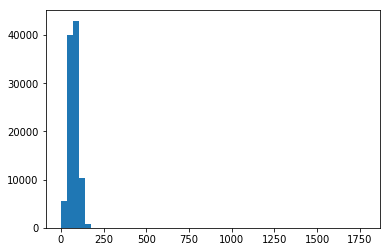

In [47]:
plt.hist(list(map(len,X)),bins=50);

In [48]:
import pickle
!mkdir generated_data
with open('generated_data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [49]:
with open('generated_data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)